# Overview

Welcome to the 2018 RSNA Challenge co-hosted by Kaggle. In this competition, the primary endpoint will be the detection of bounding boxes corresponding to the diagnosis of pneumonia (e.g. lung infection) on chest radiographs, a special 2D high resolution grayscale medical image. Note that pnuemonia is just one of many possible disease processes that can occur on a chest radiograph, and that any given single image may contain 0, 1 or many boxes corresponding to possible pneumonia locations.

My name is Peter Chang, MD. I am both a radiologist physician and a data scientist / software engineer with machine learning experience. Today, in this Jupyter notebook, we will explore the 2018 RSNA Challenge dataset including underlying data structures, imaging file formats and label types.

In [1]:
import glob, pylab, pandas as pd
import pydicom, numpy as np
from PIL import Image

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
import sys
sys.path.append("/home/paperspace/fastai")

In [10]:
torch.cuda.set_device(0)

In [3]:
from fastai.imports import *
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# Challenge Data



In [4]:
PATH = '/home/paperspace/data/pneumonia/'
!ls {PATH}

GCP%20Credits%20Request%20Link%20-%20RSNA.txt  stage_1_test_images
models					       stage_1_train_images
stage_1_detailed_class_info.csv		       stage_1_train_labels.csv
stage_1_sample_submission.csv		       tmp


The several key items in this folder:
* `stage_1_train_labels.csv`: CSV file containing training set patientIds and  labels (including bounding boxes)
* `stage_1_detailed_class_info.csv`: CSV file containing detailed labels (explored further below)
* `stage_1_train_images/`:  directory containing training set raw image (DICOM) files

Let's go ahead and take a look at the first labels CSV file first:

In [11]:
df = pd.read_csv(PATH+'stage_1_train_labels.csv')
print(df.iloc[0])

patientId    0004cfab-14fd-4e49-80ba-63a80b6bddd6
x                                             NaN
y                                             NaN
width                                         NaN
height                                        NaN
Target                                          0
Name: 0, dtype: object


# Overview of DICOM files and medical images

Medical images are stored in a special format known as DICOM files (`*.dcm`). They contain a combination of header metadata as well as underlying raw image arrays for pixel data. In Python, one popular library to access and manipulate DICOM files is the `pydicom` module. To use the `pydicom` library, first find the DICOM file for a given `patientId` by simply looking for the matching file in the `stage_1_train_images/` folder, and the use the `pydicom.read_file()` method to load the data:

In [12]:
patientId = df['patientId'][0]
dcm_file = PATH+'stage_1_train_images/%s.dcm' %patientId 
dcm_data = pydicom.read_file(dcm_file)

In [13]:
im = dcm_data.pixel_array
print(type(im))
print(im.dtype)
print(im.shape)
im[0][0]

<class 'numpy.ndarray'>
uint8
(1024, 1024)


144

# Convert DICOMS to JPGS

In [14]:
def savejpg(im,label):
    
    FNAME = label+'.jpg'
    img=Image.fromarray(im)
    img.save(PATH+'stage_1_train_images/'+FNAME)

In [20]:
from time import *
time2=time()
for i in range(18000,len(df)):

    patientId = df['patientId'][i]
    dcm_file = PATH+'stage_1_train_images/%s.dcm' %patientId 
    dcm_data = pydicom.read_file(dcm_file)
    im = dcm_data.pixel_array
    savejpg(im,patientId)

    if i%100==0: 
        time_now = time()-time2
        print("printed: ",i)
        print("time elapsed this set:", time_now)
        time_remain = (len(df)-i)/100*time_now//60
        print("est time remaining: %i mins" %time_remain)
        time2 = time()

printed:  18000
time elapsed this set: 0.03632187843322754
est time remaining: 0 mins
printed:  18100
time elapsed this set: 3.6177709102630615
est time remaining: 6 mins
printed:  18200
time elapsed this set: 3.610618829727173
est time remaining: 6 mins
printed:  18300
time elapsed this set: 3.542236328125
est time remaining: 6 mins
printed:  18400
time elapsed this set: 3.497288465499878
est time remaining: 6 mins
printed:  18500
time elapsed this set: 3.5324530601501465
est time remaining: 6 mins
printed:  18600
time elapsed this set: 3.5130956172943115
est time remaining: 6 mins
printed:  18700
time elapsed this set: 3.518131971359253
est time remaining: 6 mins
printed:  18800
time elapsed this set: 3.5037405490875244
est time remaining: 5 mins
printed:  18900
time elapsed this set: 3.5038068294525146
est time remaining: 5 mins
printed:  19000
time elapsed this set: 3.456662654876709
est time remaining: 5 mins
printed:  19100
time elapsed this set: 3.4483790397644043
est time remai

printed:  27700
time elapsed this set: 3.5565264225006104
est time remaining: 0 mins
printed:  27800
time elapsed this set: 3.524925947189331
est time remaining: 0 mins
printed:  27900
time elapsed this set: 3.452594757080078
est time remaining: 0 mins
printed:  28000
time elapsed this set: 3.4931957721710205
est time remaining: 0 mins
printed:  28100
time elapsed this set: 3.527534246444702
est time remaining: 0 mins
printed:  28200
time elapsed this set: 3.421755313873291
est time remaining: 0 mins
printed:  28300
time elapsed this set: 3.497297763824463
est time remaining: 0 mins
printed:  28400
time elapsed this set: 3.472107172012329
est time remaining: 0 mins
printed:  28500
time elapsed this set: 3.4863810539245605
est time remaining: 0 mins
printed:  28600
time elapsed this set: 3.5328619480133057
est time remaining: 0 mins
printed:  28700
time elapsed this set: 3.4663968086242676
est time remaining: 0 mins
printed:  28800
time elapsed this set: 3.472722053527832
est time remai

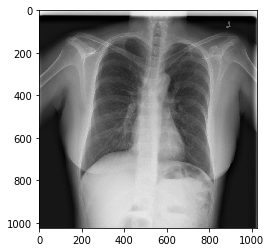

In [22]:
img = plt.imread(f'{PATH}stage_1_train_images/'+df['patientId'][10000]+'.jpg')
plt.imshow(img);

## Considerations

As we can see here, the pixel array data is stored as a Numpy array, a powerful numeric Python library for handling and manipulating matrix data (among other things). In addition, it is apparent here that the original radiographs have been preprocessed for us as follows:

* The relatively high dynamic range, high bit-depth original images have been rescaled to 8-bit encoding (256 grayscales). For the radiologists out there, this means that the images have been windowed and leveled already. In clinical practice, manipulating the image bit-depth is typically done manually by a radiologist to highlight certain disease processes. To visually assess the quality of the automated bit-depth downscaling and for considerations on potentially improving this baseline, consider consultation with a radiologist physician.

* The relativley large original image matrices (typically acquired at >2000 x 2000) have been resized to the data-science friendly shape of 1024 x 1024. For the purposes of this challenge, the diagnosis of most pneumonia cases can typically be made at this resolution. To visually assess the feasibility of diagnosis at this resolution, and to determine the optimal resolution for pneumonia detection (oftentimes can be done at a resolution *even smaller* than 1024 x 1024), consider consultation with a radiogist physician.

## Visualizing An Example

To take a look at this first DICOM image, let's use the `pylab.imshow()` method:

(-0.5, 1023.5, 1023.5, -0.5)

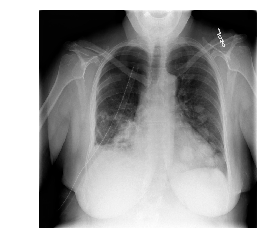

In [52]:
pylab.imshow(im, cmap=pylab.cm.gist_gray)
pylab.axis('off')

# Exploring the Data and Labels

As alluded to above, any given patient may potentially have many boxes if there are several different suspicious areas of pneumonia. To collapse the current CSV file dataframe into a dictionary with unique entries, consider the following method:

In [61]:
def parse_data(df):
    """
    Method to read a CSV file (Pandas dataframe) and parse the 
    data into the following nested dictionary:

      parsed = {
        
        'patientId-00': {
            'dicom': path/to/dicom/file,
            'label': either 0 or 1 for normal or pnuemonia, 
            'boxes': list of box(es)
        },
        'patientId-01': {
            'dicom': path/to/dicom/file,
            'label': either 0 or 1 for normal or pnuemonia, 
            'boxes': list of box(es)
        }, ...

      }

    """
    # --- Define lambda to extract coords in list [y, x, height, width]
    extract_box = lambda row: [row['y'], row['x'], row['height'], row['width']]

    parsed = {}
    for n, row in df.iterrows():
        # --- Initialize patient entry into parsed 
        pid = row['patientId']
        if pid not in parsed:
            parsed[pid] = {
                'dicom': PATH+'stage_1_train_images/%s.dcm' % pid,
                'label': row['Target'],
                'boxes': []}

        # --- Add box if opacity is present
        if parsed[pid]['label'] == 1:
            parsed[pid]['boxes'].append(extract_box(row))

    return parsed

Let's use the method here:

In [62]:
parsed = parse_data(df)

As we saw above, patient `00436515-870c-4b36-a041-de91049b9ab4` has pnuemonia so lets check our new `parsed` dict here to see the patients corresponding bounding boxes:

In [63]:
print(parsed['00436515-870c-4b36-a041-de91049b9ab4'])

{'dicom': '/home/paperspace/data/pneumonia/stage_1_train_images/00436515-870c-4b36-a041-de91049b9ab4.dcm', 'label': 1, 'boxes': [[152.0, 264.0, 379.0, 213.0], [152.0, 562.0, 453.0, 256.0]]}


# Visualizing Boxes

In order to overlay color boxes on the original grayscale DICOM files, consider using the following  methods (below, the main method `draw()` requires the method `overlay_box()`):

In [64]:
def draw(data):
    """
    Method to draw single patient with bounding box(es) if present 

    """
    # --- Open DICOM file
    d = pydicom.read_file(data['dicom'])
    im = d.pixel_array

    # --- Convert from single-channel grayscale to 3-channel RGB
    im = np.stack([im] * 3, axis=2)

    # --- Add boxes with random color if present
    for box in data['boxes']:
        rgb = np.floor(np.random.rand(3) * 256).astype('int')
        im = overlay_box(im=im, box=box, rgb=rgb, stroke=6)

    pylab.imshow(im, cmap=pylab.cm.gist_gray)
    pylab.axis('off')

def overlay_box(im, box, rgb, stroke=1):
    """
    Method to overlay single box on image

    """
    # --- Convert coordinates to integers
    box = [int(b) for b in box]
    
    # --- Extract coordinates
    y1, x1, height, width = box
    y2 = y1 + height
    x2 = x1 + width

    im[y1:y1 + stroke, x1:x2] = rgb
    im[y2:y2 + stroke, x1:x2] = rgb
    im[y1:y2, x1:x1 + stroke] = rgb
    im[y1:y2, x2:x2 + stroke] = rgb

    return im

As we saw above, patient `00436515-870c-4b36-a041-de91049b9ab4` has pnuemonia so let's take a look at the overlaid bounding boxes:

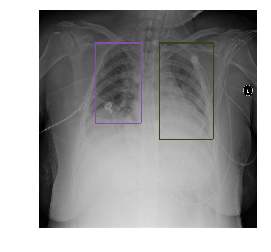

In [65]:
draw(parsed['00436515-870c-4b36-a041-de91049b9ab4'])

## Exploring Detailed Labels

In this challenge, the primary endpoint will be the detection of bounding boxes consisting of a binary classification---e.g. the presence or absence of pneumonia. However, in addition to the binary classification, each bounding box *without* pneumonia is further categorized into *normal* or *no lung opacity / not normal*. This extra third class indicates that while pneumonia was determined not to be present, there was nonetheless some type of abnormality on the image---and oftentimes this finding may mimic the appearance of true pneumonia. Keep in mind that this extra class is provided as supplemental information to help improve algorithm accuracy if needed; generation of this separate class **will not** be a formal metric used to evaluate performance in this competition.

As above, we saw that the first patient in the CSV file did not have pneumonia. Let's look at the detailed label information for this patient:

In [66]:
df_detailed = pd.read_csv(PATH+'stage_1_detailed_class_info.csv')
print(df_detailed.iloc[0])

patientId    0004cfab-14fd-4e49-80ba-63a80b6bddd6
class                No Lung Opacity / Not Normal
Name: 0, dtype: object


As we see here, the patient does not have pneumonia however *does* have another imaging abnormality present. Let's take a closer look:

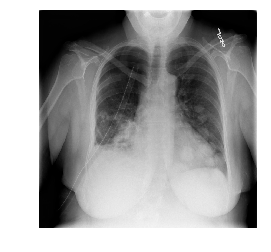

In [67]:
patientId = df_detailed['patientId'][0]
draw(parsed[patientId])

While the image displayed inline within the notebook is small, as a radiologist it is evident that the patient has several well circumscribed nodular densities in the left lung (right side of image). In addition there is a large chest tube in the right lung (left side of the image) which has been placed to drain fluid accumulation (e.g. pleural effusion) at the right lung base that also demonstrates overlying patchy densities (e.g. possibly atelectasis or partial lung collapse).

As you can see, there are a number of abnormalities on the image, and the determination that none of these findings correlate to pneumonia is somewhat subjective even among expert physicians. Therefore, as is almost always the case in medical imaging datasets, the provided ground-truth labels are far from 100% objective. Keep this in mind as you develop your algorithm, and consider consultation with a radiologist physician to help determine an optimal strategy for mitigating these discrepencies.

## Label Summary

Finally, let us take a closer look at the distribution of labels in the dataset. To do so we will first parse the detailed label information:

In [68]:
summary = {}
for n, row in df_detailed.iterrows():
    if row['class'] not in summary:
        summary[row['class']] = 0
    summary[row['class']] += 1
    
print(summary)

{'No Lung Opacity / Not Normal': 11500, 'Normal': 8525, 'Lung Opacity': 8964}


As we can see, there is a relatively even split between the three classes, with nearly 2/3rd of the data comprising of no pneumonia (either completely *normal* or *no lung opacity / not normal*). Compared to most medical imaging datasets, where the prevalence of disease is quite low, this dataset has been significantly enriched with pathology.

# Next Steps

Now that you understand the data structures, imaging file formats and label types, it's time to make an algorithm! Keep in mind that the primary endpoint is the detection of bounding boxes, thus you will likely be considering various **object localization** algorithms. An alternative strategy is to consider the related family of **segmentation** algorithms with the acknowledgement that bounding boxes will only be a coarse approximation to true pixel-by-pixel image segmentation masks.

Finally, as alluded to several times in this notebook, a radiologist physican may often times provide useful ancillary information, strategy for algorithm development and/or additional label reconciliation. In addition to physicians you may have access to locally, the RSNA will reach out to radiologists and facilitate engagement remotely through the Kaggle online forums. As a medical professional, I know that many of my colleagues are very interested in getting started so please feel free to reach out and start a conversation! 

Good luck!

# Classify Images

In [5]:
sz=224
arch=resnext101_64
bs=58

In [6]:
label_csv = f'{PATH}stage_1_detailed_class_info.csv'
n=len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)

In [31]:
label_df=pd.read_csv(label_csv)
label_df.head()

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


In [34]:
label_df.pivot_table(index='class', aggfunc=len).sort_values('patientId', ascending=False)

,patientId
class,
No Lung Opacity / Not Normal,11500
Lung Opacity,8964
Normal,8525


In [7]:
tfms = tfms_from_model(arch, sz, max_zoom=1.1)
data = ImageClassifierData.from_csv(PATH, 'stage_1_train_images', f'{PATH}stage_1_detailed_class_info.csv', val_idxs=val_idxs, suffix='.jpg', tfms=tfms, bs=bs)

In [8]:
learn = ConvLearner.pretrained(arch, data, precompute=False)

In [41]:
learn.fit(1e-2,3)

epoch      trn_loss   val_loss   <lambda>                    
    0      0.508388   0.464795   0.767753  
    1      0.474561   0.455829   0.772411                    
    2      0.468346   0.452796   0.775574                    


[array([0.4528]), 0.7755735731030283]

In [44]:
lrf = learn.lr_find()

 95%|█████████▍| 379/400 [08:43<00:29,  1.38s/it, loss=1.66] 

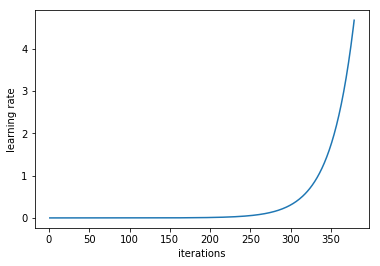

In [45]:
learn.sched.plot_lr()

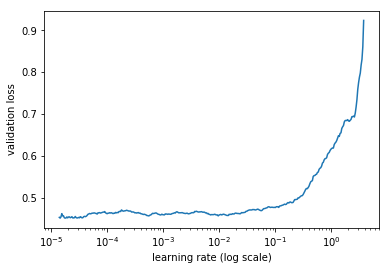

In [46]:
learn.sched.plot()

In [11]:
lr_old=10e-2
lr = np.array([lr_old/9,lr_old/3,lr_old])
learn.unfreeze()
learn.fit(lr,3,cycle_len=1, cycle_mult=2)

  0%|          | 0/400 [00:00<?, ?it/s]


RuntimeError: cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1518244421288/work/torch/lib/THC/generic/THCStorage.cu:58